# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Importing libraries

In [1]:
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
import numpy as np
import pandas as pd
import os 
import time
import sys

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Data Exploration


In [2]:
# load the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

F:\Anacinda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
attributes_values = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', header=1)
attributes_desc = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', header=1)

##### I received a warning when loading the data. It happened because of mixed data type in 2 columns. I handled the mixed type by replacing ‘X’ with nan value.

In [4]:
azdias.iloc[:,18:20].columns

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [5]:
azdias[['CAMEO_INTL_2015','CAMEO_DEUG_2015']].head()

,CAMEO_INTL_2015,CAMEO_DEUG_2015
0,NaN,NaN
1,51,8
2,24,4
3,12,2
4,43,6


In [6]:
azdias['CAMEO_INTL_2015'].value_counts()

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

In [7]:
azdias['CAMEO_DEUG_2015'].value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

In [8]:
azdias[azdias.columns[azdias.dtypes == 'object']]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7,41,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4,24,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9,51,D19_UNBEKANNT,1992-02-12 00:00:00,W


##### The problem of mixed types in columns is because there is actually a mix of int and string values.  I will remove the string value and convert the column datatypt to float.

In [9]:
def handle_mixed_types(df):
    '''This function is created for formating improper 
    values in columns CAMEO_DEUG_2015 and CAMEO_INTL_2015.
    Args:
    df: demographics dataframe
    returns: transformed dataframe
    '''
    cols_nan = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']
    cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    if set(cols_nan).issubset(df.columns):
        df[cols_nan] = df[cols_nan].replace({'X': np.nan, 'XX': np.nan})
        df[cols] = df[cols].astype(float)
    return df

In [10]:
customers = handle_mixed_types(customers)

In [11]:
customers.groupby("CAMEO_DEUG_2015")["CAMEO_DEUG_2015"].count()

CAMEO_DEUG_2015
1.0    16778
2.0    23484
3.0    18390
4.0    22064
5.0    11666
6.0    18717
7.0    10558
8.0    13049
9.0     6392
Name: CAMEO_DEUG_2015, dtype: int64

In [12]:
customers.groupby("CAMEO_INTL_2015")["CAMEO_INTL_2015"].count()

CAMEO_INTL_2015
12.0     3715
13.0     7683
14.0    19647
15.0     9217
22.0     7507
23.0     5770
24.0    17805
25.0     9372
31.0     2731
32.0     1696
33.0     1574
34.0     5368
35.0     2294
41.0    11320
43.0     9634
44.0     2832
45.0     5288
51.0     8113
52.0     1023
54.0     4795
55.0     3714
Name: CAMEO_INTL_2015, dtype: int64

In [13]:
customers['CAMEO_DEU_2015'].unique()

array(['1A', nan, '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B',
       '9D', '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D',
       '2A', '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E',
       '5E', '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F',
       '4D'], dtype=object)

In [14]:
azdias = handle_mixed_types(azdias)

##### Looking at the attributes files

In [15]:
attributes_desc.drop(columns=['Unnamed: 0'], inplace=True)
attributes_values.drop(columns=['Unnamed: 0'], inplace=True)

In [16]:
attributes_values['Attribute'] = attributes_values['Attribute'].ffill()
attributes_values['Description'] = attributes_values['Description'].ffill()

### Imputation: Replace missing values

In [17]:
unknown = {}
for i, row in attributes_values.iterrows():
    if "unknown" in str(row['Meaning']):
        unknown[row['Attribute']] = [int(num) for num in str(row['Value']).split(', ')]

There are 2 types of the missing data:
1. NaN in the dataframe
2. X and XX values in columns 18 and 19, that we converted to NANs.

In [18]:
def replace_unknown(df, dictionary):
    '''This function accept a dataframe which is 
    going to be check for the missing values accorfing 
    to the dictionary and if such exists it will be replaced with numpy.nan.
    Args:
    df: demographics dataframe
    dictionary: dictionary which contains encodings for unknown values for each column of the dataset
    returns: none
    '''
    for key, value in dictionary.items():
        if key in df.columns:
            for i in range(0, len(value)):
                df.loc[df[key] == value[i], key] = np.nan

In [19]:
filtered_customers = customers.copy()
filtered_azdias = azdias.copy()
replace_unknown(filtered_customers, unknown)
replace_unknown(filtered_azdias, unknown)

### Outliers

I want to verify if there are some outliers in the dataset. I can detect outliers using values in the DIAS Attributes - Values 2017.xlsx file. Everyting which is beyond those descriptions can be considered as outliers.

In [20]:
def get_unique_values(df):
    '''This function accept a dataframe for which it will 
    calculate the range of its actual values.
    Args:
    df: demographics dataframe
    returns: dictionary with unique ranges for every column
    in the given dataframe.
    '''
    dict_unique_values = {}
    for col in df.columns:
        if col != "LNR":
            dict_unique_values[col] = df[col].unique()
    return dict_unique_values

In [21]:
def get_ranges():
    '''This function gathers the information on the
    proper ranges for every column of the dataset.
    Args:
    none
    returns: dictionary with unique ranges for every column
    of the dataset.
    '''
    dict_of_attr = {}
    for i, row in attributes_values.iterrows():
        if row['Attribute'] in dict_of_attr:
            dict_of_attr[row['Attribute']].append(row['Value'])
        else:
            dict_of_attr[row['Attribute']] = [row['Value']]
    return dict_of_attr

##### From this, I can see that CAMEO_DEU_2015, CAMEO_DEUINTL_2015, LP_LEBENSPHASE_FEIN, PRAEGENDE_JUGENDJAHRE are definitely overcategorised.

In [22]:
def get_difference(actual_entries_dictionary):
    '''This function accepts the dictionary with actual 
    data ranges of the dataframe and compares them with the ones
    that are correct gathers. Function returns the outliers 
    for each column is such exist. 
    Args: 
    actual_entries_dictionary: dictionary with actual entries 
    returns: dictionary with outliers for each column.
    '''
    dict_of_outliers = {}
    for key, value in actual_entries_dictionary.items():
        if key in attributes_proper_range:
            dict_of_outliers[key] = [item for item in value if item not in attributes_proper_range[key]]
    return dict_of_outliers

In [23]:
additional_missing_values = {'KBA05_MODTEMP': [6.0], 'LP_FAMILIE_FEIN': [0.0], 'LP_FAMILIE_GROB': [0.0],
                            'LP_LEBENSPHASE_FEIN': [0.0], 'LP_LEBENSPHASE_GROB': [0.0], 'ORTSGR_KLS9': [0.0], 'GEBURTSJAHR': [0]}

replace_unknown(filtered_customers, additional_missing_values)
replace_unknown(filtered_azdias, additional_missing_values)

In [24]:
def remove_outliers(df, sub_df):
    """
    Remove outliers from the dataframe
    """
    lower = sub_df.quantile(0.25)
    upper = sub_df.quantile(0.75)
    IQR = upper - lower
    df = df[~((sub_df < (lower - 1.5 * IQR)) | (sub_df > (upper + 1.5 * IQR))).any(axis=1)]

##### Removing outliers in the next step

In [25]:
remove_outliers(filtered_azdias, filtered_azdias[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'KBA13_ANZAHL_PKW']])
remove_outliers(filtered_customers, filtered_azdias[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'KBA13_ANZAHL_PKW']])

<ipython-input-24-286a1a7ec023>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~((sub_df < (lower - 1.5 * IQR)) | (sub_df > (upper + 1.5 * IQR))).any(axis=1)]


### Detect missing data

In [26]:
def detect_missing_data(df):
    """
    Detect missing data in the dataframe
    """
    
    missing_cols_df = pd.Series(df.isna().sum(), name='num').to_frame()
    missing_cols_df = missing_cols_df.assign(percentage=lambda x: round((x.num * 100 / df.shape[0]),2))
    
    missing_rows_df = pd.Series(df.isna().sum(axis=1)[df.isna().sum(axis=1)>183], name='num').to_frame()
    missing_rows_df = missing_rows_df.assign(percentage=lambda x: round((x.num * 100 / df.shape[1]),2))
    
    return missing_cols_df, missing_rows_df 

In [27]:
azdias_missing_cols_df, azdias_missing_rows_df = detect_missing_data(filtered_azdias)

In [28]:
customers_missing_cols_df, customers_missing_rows_df = detect_missing_data(filtered_customers)

#### Columns having extremely high percentage of the missing data in "Azdias" dataset

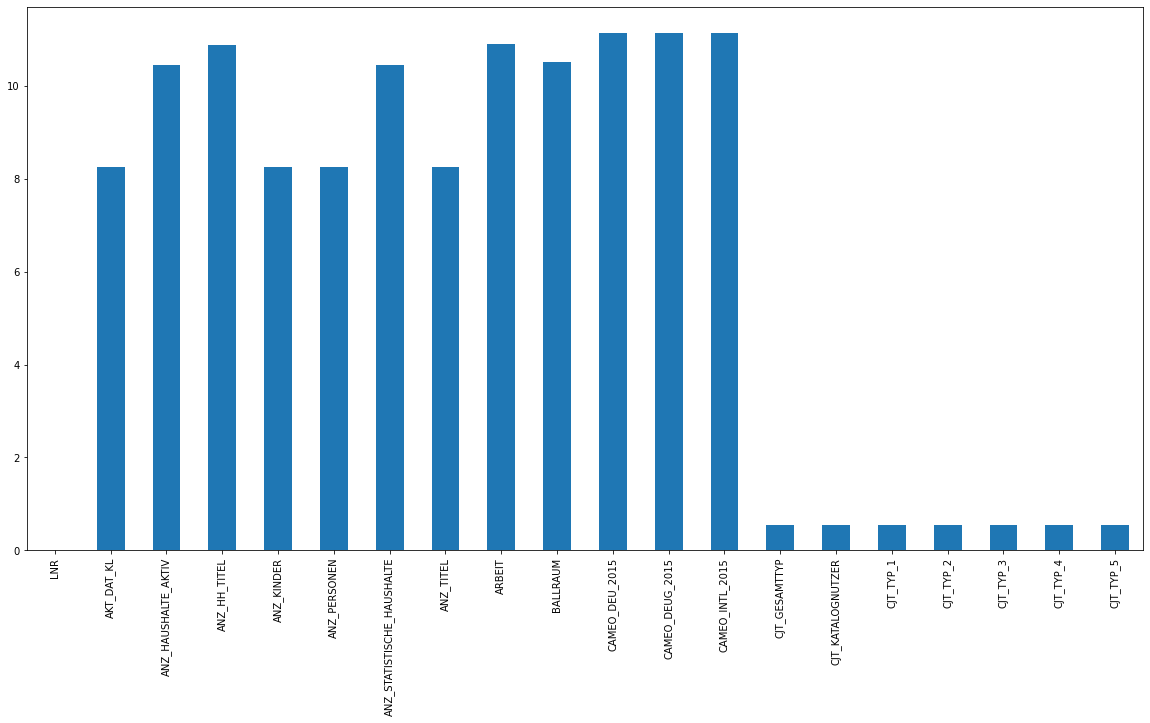

In [29]:
azdias_missing_cols_df[azdias_missing_cols_df.percentage < 20].percentage[:20].plot(figsize = (20, 10), kind = 'bar');
plt.show()

#### Columns having extremely high percentage of the missing data in "Customers" dataset

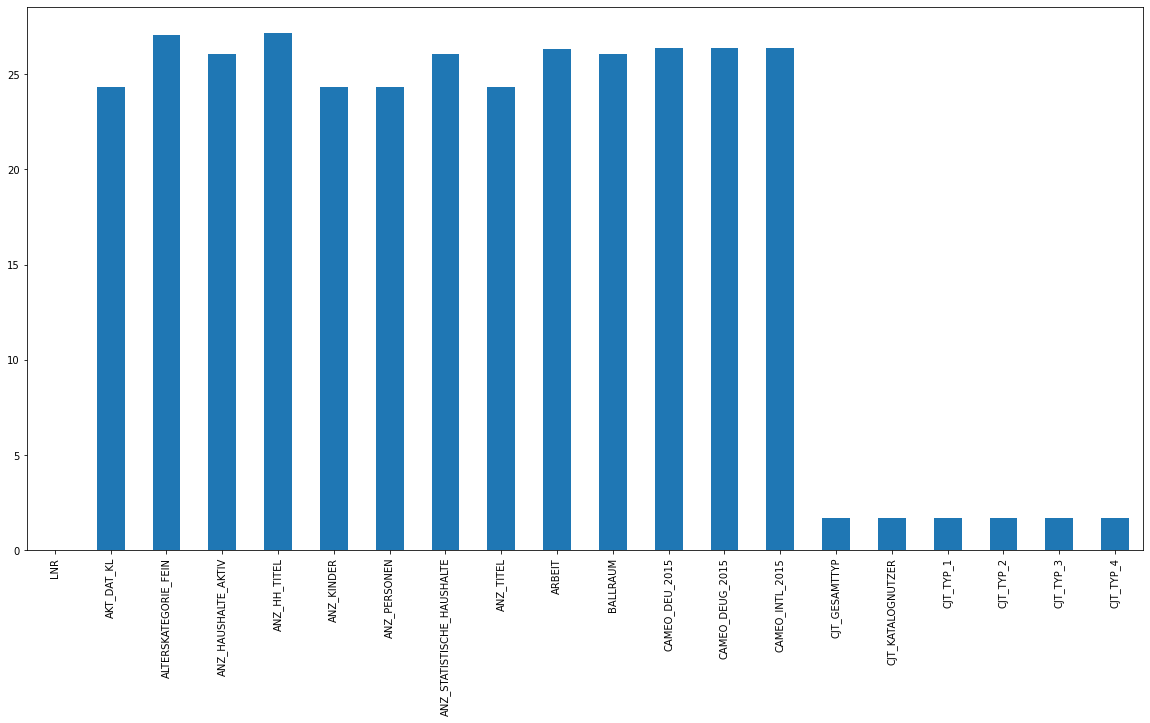

In [30]:
customers_missing_cols_df[customers_missing_cols_df.percentage < 30].percentage[:20].plot(figsize = (20, 10), kind = 'bar');
plt.show()

##### Comparing the missing data from AZDIAS with CUSTOMERS. In order to to this, merging dataframes by column.

In [31]:
merged = azdias_missing_cols_df.reset_index()
merged.rename(columns={'percentage':'azdias_%'}, inplace=True)
del merged["num"]
merged

,index,azdias_%
0,LNR,0.00
1,AGER_TYP,76.02
2,AKT_DAT_KL,8.25
3,ALTER_HH,34.81
4,ALTER_KIND1,90.90
...,...,...
361,WOHNDAUER_2008,8.25
362,WOHNLAGE,10.45
363,ZABEOTYP,0.00
364,ANREDE_KZ,0.00


In [32]:
temp_cus = customers_missing_cols_df.reset_index()
temp_cus.rename(columns={'percentage':'customers_%'}, inplace=True)
del temp_cus["num"]
temp_cus

,index,customers_%
0,LNR,0.00
1,AGER_TYP,48.06
2,AKT_DAT_KL,24.31
3,ALTER_HH,35.87
4,ALTER_KIND1,93.86
...,...,...
364,PRODUCT_GROUP,0.00
365,CUSTOMER_GROUP,0.00
366,ONLINE_PURCHASE,0.00
367,ANREDE_KZ,0.00


In [33]:
merged = merged.merge(temp_cus, on='index')
merged

,index,azdias_%,customers_%
0,LNR,0.00,0.00
1,AGER_TYP,76.02,48.06
2,AKT_DAT_KL,8.25,24.31
3,ALTER_HH,34.81,35.87
4,ALTER_KIND1,90.90,93.86
...,...,...,...
361,WOHNDAUER_2008,8.25,24.31
362,WOHNLAGE,10.45,26.05
363,ZABEOTYP,0.00,0.00
364,ANREDE_KZ,0.00,0.00


In [34]:
merged_unique = set(list(merged['index']))

In [35]:
cols_to_drop = list(merged.loc[(merged['azdias_%'] > 30) & (merged['customers_%'] > 30)]['index'])
cols_to_drop

['AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'GEBURTSJAHR',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

In [36]:
filtered_azdias = filtered_azdias.drop(cols_to_drop, axis = 1)
filtered_customers = filtered_customers.drop(cols_to_drop, axis = 1)

In [37]:
print(filtered_azdias.shape)
print(filtered_customers.shape)

(891221, 355)
(191652, 358)


In [38]:
customers_unique = set(list(customers.columns))
azdias_unique = set(list(azdias.columns))
attributes_desc_unique = set(list(attributes_desc.Attribute))
attributes_values_unique = set(list(attributes_values.Attribute))
common = customers_unique & azdias_unique & attributes_desc_unique

In [39]:
cols_to_drop = list((set(filtered_azdias.columns) & set(filtered_customers.columns)).difference(attributes_desc_unique))

In [40]:
filtered_azdias = filtered_azdias.drop(cols_to_drop, axis = 1)
filtered_customers = filtered_customers.drop(cols_to_drop, axis = 1)

In [41]:
azdias_missing_cols_df, azdias_missing_rows_df = detect_missing_data(filtered_azdias)

In [42]:
customers_missing_cols_df, customers_missing_rows_df = detect_missing_data(filtered_customers)

In [43]:
def drop_rows(df, missing_rows):
    '''This function deletes rows which are mentioned in the dataframe. 
    Args: 
    df: demographic dataframe
    missing_rows: dataframe which contained information on rows that should be removed 
    returns: updated dataframe
    '''
    return df[~df.index.isin(missing_rows.index)]

In [44]:
filtered_azdias = drop_rows(filtered_azdias, azdias_missing_rows_df)
filtered_customers = drop_rows(filtered_customers, customers_missing_rows_df)

### Feature Engineering

* `CAMEO_INTL_2015` into `CAMEO_INTL_2015_wealth_type` and `CAMEO_INTL_2015_family_type`
* `LP_LEBENSPHASE_FEIN` into `LP_LEBENSPHASE_FEIN_family_type`, `LP_LEBENSPHASE_FEIN_earner_type`, `LP_LEBENSPHASE_FEIN_age_group`
* `PRAEGENDE_JUGENDJAHRE` by movent type (avangard or mainstream) and decade


In [45]:
def engineering(df):
    '''This function deals designated columns and imputes missing data. 
    Args: 
    df: demographic dataframe
    returns: none
    '''
    labelencoder = LabelEncoder()
    
    df['ANZ_HAUSHALTE_AKTIV'].fillna(df['ANZ_HAUSHALTE_AKTIV'].mean(), inplace=True)
    print('Replaced ANZ_HAUSHALTE_AKTIV')
    df['KBA13_ANZAHL_PKW'].fillna(df['KBA13_ANZAHL_PKW'].mean(), inplace=True)
    print('Replaced KBA13_ANZAHL_PKW')
    
    cameo_wealth_type = {
        11:'Wealthy', 12:'Wealthy',13:'Wealthy', 14:'Wealthy', 15:'Wealthy', 
        21:'Prosperous', 22:'Prosperous', 23:'Prosperous', 24:'Prosperous', 25:'Prosperous',
        31:'Comfortable', 32:'Comfortable', 33:'Comfortable', 34:'Comfortable', 35:'Comfortable',
        41:'Less Affluent', 42:'Less Affluent', 43:'Less Affluent', 44:'Less Affluent', 45:'Less Affluent',
        51:'Poorer', 52:'Poorer', 53:'Poorer', 54:'Poorer', 55:'Poorer'
    }
    cameo_family_type = {
        11:'Pre-Family Couples & Singles',
        12:'Young Couples With Children',
        13:'Families With School Age Children',
        14:'Older Families &  Mature Couples',
        15:'Elders In Retirement',
        21:'Pre-Family Couples & Singles',
        22:'Young Couples With Children',
        23:'Families With School Age Children',
        24:'Older Families &  Mature Couples',
        25:'Elders In Retirement',
        31:'Pre-Family Couples & Singles',
        32:'Young Couples With Children',
        33:'Families With School Age Children',
        34:'Older Families &  Mature Couples',
        35:'Elders In Retirement',
        41:'Pre-Family Couples & Singles',
        42:'Young Couples With Children',
        43:'Families With School Age Children',
        44:'Older Families &  Mature Couples',
        45:'Elders In Retirement',
        51:'Pre-Family Couples & Singles',
        52:'Young Couples With Children',
        53:'Families With School Age Children',
        54:'Older Families &  Mature Couples',
        55:'Elders In Retirement',

    }
    
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth_type'] = df['CAMEO_INTL_2015'].map(cameo_wealth_type)
        df['CAMEO_INTL_2015_family_type'] = df['CAMEO_INTL_2015'].map(cameo_family_type)
    
    family_type_dict = {
        1: 'single', 2: 'single', 3: 'single', 4: 'single', 5: 'single', 6: 'single', 7: 'single',
        8: 'single', 9: 'single', 10:'single', 11:'single', 12:'single', 13:'single', 14:'couples',
        15:'couples', 16:'couples', 17:'couples', 18:'couples', 19:'couples', 20:'couples', 21:'single_parent',
        22:'single_parent', 23:'single_parent', 24:'families', 25:'families', 26:'families', 27:'families', 28:'families',
        29:'mulitperson_households', 30:'mulitperson_households', 31:'mulitperson_households', 32:'mulitperson_households',
        33:'mulitperson_households', 34:'mulitperson_households', 35:'mulitperson_households', 36:'mulitperson_households',
        37:'mulitperson_households', 38:'mulitperson_households', 39:'mulitperson_households', 40:'mulitperson_households'
    }
    earner_type_dict = {
        1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low', 7: 'average',
        8: 'average', 9: 'independant', 10:'wealthy', 11:'homeowners', 12:'homeowners', 13:'top', 14:'low',
        15: 'low', 16:'average', 17: 'independant', 18:'wealthy', 19:'homeowners', 20:'top', 21:'low',
        22: 'average', 23:'high', 24:'low', 25:'average', 26: 'independant', 27:'homeowners', 28:'top',
        29: 'low', 30:'average', 31:'low', 32:'average',
        33: 'independant', 34:'homeowners', 35:'top', 36: 'independant',
        37: 'homeowners', 38:'homeowners', 39:'top', 40:'top'
    }
    age_group_dict = {
        1: 'younger_age', 2: 'middle_age', 3: 'younger_age', 4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age', 7: 'advanced_age',
        8: 'retirement_age', 9: np.nan, 10: np.nan, 11:'advanced_age', 12:'retirement_age', 13:'higher_age', 14:'younger_age',
        15: 'higher_age', 16:'higher_age', 17: np.nan, 18:'younger_age', 19:'higher_age', 20:'higher_age', 21: np.nan,
        22: np.nan, 23:np.nan, 24:np.nan, 25:np.nan, 26: np.nan, 27:np.nan, 28:np.nan,
        29: 'younger_age', 30:'younger_age', 31:'higher_age', 32:'higher_age',
        33: 'younger_age', 34:'younger_age', 35:'younger_age', 36: 'higher_age',
        37: 'advanced_age', 38:'retirement_age', 39:'middle_age', 40:'retirement_age'
    }
    
    if 'LP_LEBENSPHASE_FEIN' in df.columns:
        df['LP_LEBENSPHASE_FEIN_family_type'] = df['LP_LEBENSPHASE_FEIN'].map(family_type_dict)
        df['LP_LEBENSPHASE_FEIN_earner_type'] = df['LP_LEBENSPHASE_FEIN'].map(earner_type_dict)
        df['LP_LEBENSPHASE_FEIN_age_group'] = df['LP_LEBENSPHASE_FEIN'].map(age_group_dict)
    
    family_type_dict = {
        1: 'single', 2: 'couple', 3: 'single_parent', 4: 'single_parent', 5: 'single_parent', 
        6: 'family', 7: 'family', 8: 'family', 9: 'mulitperson_households', 10: 'mulitperson_households', 
        11: 'mulitperson_households'
    }
    if 'LP_FAMILIE_GROB' in df.columns:
        df['LP_FAMILIE_GROB_family_type'] = df['LP_FAMILIE_GROB'].map(family_type_dict)
    
    earner_type_dict = {
        1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'average', 
        6: 'independant', 7: 'independant', 8: 'houseowners', 9: 'houseowners', 10: 'top'
    }
    if 'LP_STATUS_GROB' in df.columns:
        df['LP_STATUS_GROB_earner_type'] = df['LP_STATUS_GROB'].map(earner_type_dict)
    
    movement_dict = {
        1: 'mainstream', 2: 'avantgarde', 3: 'mainstream', 4: 'avantgarde',
        5: 'mainstream', 6: 'avantgarde', 7: 'avantgarde', 8: 'mainstream', 9: 'avantgarde', 
        10: 'mainstream', 11: 'avantgarde', 12: 'mainstream', 13: 'avantgarde', 14: 'mainstream',
        15: 'avantgarde'
    }
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    print('created PRAEGENDE_JUGENDJAHRE_movement')
    decade_dict = {
        1: '40s', 2: '40s', 3: '50s', 4: '50s',
        5: '60s', 6: '60s', 7: '60s', 8: '70s', 9: '70s', 
        10: '80s', 11: '80s', 12: '80s', 13: '80s', 14: '90s',
        15: '90s'
    }
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    print('created PRAEGENDE_JUGENDJAHRE_decade')
    
    if 'EINGEFUEGT_AM' in df.columns:
        df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM']).dt.year
    
    list_of_obj_cols = ['CAMEO_INTL_2015', 'CAMEO_INTL_2015_wealth_type','CAMEO_INTL_2015_family_type',
                        'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_FEIN_family_type', 'LP_LEBENSPHASE_FEIN_earner_type', 
                        'LP_LEBENSPHASE_FEIN_age_group', 'LP_FAMILIE_GROB', 'LP_FAMILIE_GROB_family_type', 
                        'LP_STATUS_GROB', 'LP_STATUS_GROB_earner_type', 'PRAEGENDE_JUGENDJAHRE', 
                        'PRAEGENDE_JUGENDJAHRE_movement', 'PRAEGENDE_JUGENDJAHRE_decade', 'EINGEFUEGT_AM',
                        'CAMEO_INTL_2015', 'OST_WEST_KZ', 'CAMEO_DEU_2015', 'PRODUCT_GROUP', 'CUSTOMER_GROUP', 
                        'D19_LETZTER_KAUF_BRANCHE']
    for col in df.columns:
        if col in list_of_obj_cols:
            df[col].fillna(df[col].value_counts().idxmax(), inplace=True)
        else: 
            print(col)
            df[col].fillna(df[col].median(), inplace=True)
        print(f'Imputed {col}')
    
    
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth_type'] = labelencoder.fit_transform(df['CAMEO_INTL_2015_wealth_type'])
        df['CAMEO_INTL_2015_family_type'] = labelencoder.fit_transform(df['CAMEO_INTL_2015_family_type'])
    
    if 'LP_LEBENSPHASE_FEIN_family_type' in df.columns:
        df['LP_LEBENSPHASE_FEIN_family_type'] = labelencoder.fit_transform(df['LP_LEBENSPHASE_FEIN_family_type'])
        df['LP_LEBENSPHASE_FEIN_earner_type'] = labelencoder.fit_transform(df['LP_LEBENSPHASE_FEIN_earner_type'])
        df['LP_LEBENSPHASE_FEIN_age_group'] = labelencoder.fit_transform(df['LP_LEBENSPHASE_FEIN_age_group'])

    print('Cretaed LP_LEBENSPHASE_FEIN_family_type, LP_LEBENSPHASE_FEIN_earner_type and LP_LEBENSPHASE_FEIN_age_group')
    
    if 'LP_LEBENSPHASE_FEIN_family_type' in df.columns:
        df['LP_FAMILIE_GROB_family_type'] = labelencoder.fit_transform(df['LP_FAMILIE_GROB_family_type'])

    print('Transformed LP_FAMILIE_GROB_family_type')
    
    if 'LP_LEBENSPHASE_FEIN_family_type' in df.columns:
        df['LP_STATUS_GROB_earner_type'] = labelencoder.fit_transform(df['LP_STATUS_GROB_earner_type'])

    print('Transformed LP_STATUS_GROB_earner_type')
    drop_cols = ['LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'PRAEGENDE_JUGENDJAHRE', 
                 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE']
    df.drop(drop_cols, axis = 1, inplace = True, errors='ignore')
    
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'] = labelencoder.fit_transform(df['OST_WEST_KZ'])
        print('Transformed OST_WEST_KZ')
    
    if 'CAMEO_DEU_2015' in df.columns:
        df['CAMEO_DEU_2015'] = labelencoder.fit_transform(df['CAMEO_DEU_2015'])
        print('Transformed CAMEO_DEU_2015')
    
    
    for value in ['PRODUCT_GROUP', 'CUSTOMER_GROUP']:
        if value in df.columns:
            df[value] = labelencoder.fit_transform(df[value])
            print(f'Transformed {value}')
            
    if 'PRAEGENDE_JUGENDJAHRE_movement' in df.columns:   
        df['PRAEGENDE_JUGENDJAHRE_movement'] = labelencoder.fit_transform(df['PRAEGENDE_JUGENDJAHRE_movement'])
        df['PRAEGENDE_JUGENDJAHRE_decade'] = labelencoder.fit_transform(df['PRAEGENDE_JUGENDJAHRE_decade'])

In [46]:
engineering(filtered_azdias)
engineering(filtered_customers)

Replaced ANZ_HAUSHALTE_AKTIV
Replaced KBA13_ANZAHL_PKW
created PRAEGENDE_JUGENDJAHRE_movement
created PRAEGENDE_JUGENDJAHRE_decade
ANZ_HAUSHALTE_AKTIV
Imputed ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
Imputed ANZ_HH_TITEL
ANZ_PERSONEN
Imputed ANZ_PERSONEN
ANZ_TITEL
Imputed ANZ_TITEL
ARBEIT
Imputed ARBEIT
BALLRAUM
Imputed BALLRAUM
Imputed CAMEO_DEU_2015
CAMEO_DEUG_2015
Imputed CAMEO_DEUG_2015
CJT_GESAMTTYP
Imputed CJT_GESAMTTYP
D19_BANKEN_DATUM
Imputed D19_BANKEN_DATUM
D19_BANKEN_OFFLINE_DATUM
Imputed D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
Imputed D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
Imputed D19_BANKEN_ONLINE_QUOTE_12
D19_GESAMT_DATUM
Imputed D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
Imputed D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
Imputed D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
Imputed D19_GESAMT_ONLINE_QUOTE_12
D19_KONSUMTYP
Imputed D19_KONSUMTYP
D19_TELKO_DATUM
Imputed D19_TELKO_DATUM
D19_TELKO_OFFLINE_DATUM
Imputed D19_TELKO_OFFLINE_DATUM
D19_TELKO_

KKK
Imputed KKK
KONSUMNAEHE
Imputed KONSUMNAEHE
LP_FAMILIE_FEIN
Imputed LP_FAMILIE_FEIN
Imputed LP_FAMILIE_GROB
Imputed LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
Imputed LP_LEBENSPHASE_GROB
LP_STATUS_FEIN
Imputed LP_STATUS_FEIN
Imputed LP_STATUS_GROB
MIN_GEBAEUDEJAHR
Imputed MIN_GEBAEUDEJAHR
MOBI_REGIO
Imputed MOBI_REGIO
NATIONALITAET_KZ
Imputed NATIONALITAET_KZ
ONLINE_AFFINITAET
Imputed ONLINE_AFFINITAET
ORTSGR_KLS9
Imputed ORTSGR_KLS9
Imputed OST_WEST_KZ
PLZ8_ANTG1
Imputed PLZ8_ANTG1
PLZ8_ANTG2
Imputed PLZ8_ANTG2
PLZ8_ANTG3
Imputed PLZ8_ANTG3
PLZ8_ANTG4
Imputed PLZ8_ANTG4
PLZ8_BAUMAX
Imputed PLZ8_BAUMAX
PLZ8_GBZ
Imputed PLZ8_GBZ
PLZ8_HHZ
Imputed PLZ8_HHZ
Imputed PRAEGENDE_JUGENDJAHRE
REGIOTYP
Imputed REGIOTYP
RELAT_AB
Imputed RELAT_AB
RETOURTYP_BK_S
Imputed RETOURTYP_BK_S
SEMIO_DOM
Imputed SEMIO_DOM
SEMIO_ERL
Imputed SEMIO_ERL
SEMIO_FAM
Imputed SEMIO_FAM
SEMIO_KAEM
Imputed SEMIO_KAEM
SEMIO_KRIT
Imputed SEMIO_KRIT
SEMIO_KULT
Imputed SEMIO_KULT
SEMIO_LUST
Imputed SEMIO_LUST
SEMIO_MAT
Imp

Imputed KBA13_VORB_1
KBA13_VORB_1_2
Imputed KBA13_VORB_1_2
KBA13_VORB_2
Imputed KBA13_VORB_2
KBA13_VORB_3
Imputed KBA13_VORB_3
KBA13_VW
Imputed KBA13_VW
KKK
Imputed KKK
KONSUMNAEHE
Imputed KONSUMNAEHE
LP_FAMILIE_FEIN
Imputed LP_FAMILIE_FEIN
Imputed LP_FAMILIE_GROB
Imputed LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
Imputed LP_LEBENSPHASE_GROB
LP_STATUS_FEIN
Imputed LP_STATUS_FEIN
Imputed LP_STATUS_GROB
MIN_GEBAEUDEJAHR
Imputed MIN_GEBAEUDEJAHR
MOBI_REGIO
Imputed MOBI_REGIO
NATIONALITAET_KZ
Imputed NATIONALITAET_KZ
ONLINE_AFFINITAET
Imputed ONLINE_AFFINITAET
ORTSGR_KLS9
Imputed ORTSGR_KLS9
Imputed OST_WEST_KZ
PLZ8_ANTG1
Imputed PLZ8_ANTG1
PLZ8_ANTG2
Imputed PLZ8_ANTG2
PLZ8_ANTG3
Imputed PLZ8_ANTG3
PLZ8_ANTG4
Imputed PLZ8_ANTG4
PLZ8_BAUMAX
Imputed PLZ8_BAUMAX
PLZ8_GBZ
Imputed PLZ8_GBZ
PLZ8_HHZ
Imputed PLZ8_HHZ
Imputed PRAEGENDE_JUGENDJAHRE
REGIOTYP
Imputed REGIOTYP
RELAT_AB
Imputed RELAT_AB
RETOURTYP_BK_S
Imputed RETOURTYP_BK_S
SEMIO_DOM
Imputed SEMIO_DOM
SEMIO_ERL
Imputed SEMIO_ERL
SEMIO_FA

##### I will use feature correlation across the entire dataset to determine which features are too highly-correlated.

In [47]:
def drop_cols(df):
    """
    drop columns from the dataframe
    """
    corr_matrix = df.corr().abs().round(2)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    cols_to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    return cols_to_drop

#### Setting Threshold >0.95 will be removed.

In [48]:
cols_to_drop = drop_cols(filtered_azdias)

In [49]:
filtered_azdias = filtered_azdias.drop(cols_to_drop, axis = 1)
filtered_customers = filtered_customers.drop(cols_to_drop, axis = 1)

In [50]:
def perform_log_transform(df):
    df_log = pd.DataFrame()

    for col in df.columns:
        df_log[col]=(df[col]+1).transform(np.log)
    return df_log

In [51]:
azdias_log_transformed = perform_log_transform(filtered_azdias)
customers_log_transformed = perform_log_transform(filtered_customers)

In [52]:
azdias_log_transformed.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_FEIN_family_type,LP_LEBENSPHASE_FEIN_earner_type,LP_LEBENSPHASE_FEIN_age_group,LP_FAMILIE_GROB_family_type,LP_STATUS_GROB_earner_type,PRAEGENDE_JUGENDJAHRE_decade
1,2.484907,0.0,1.098612,0.0,1.386294,1.945910,3.583519,1.791759,2.397895,2.397895,...,1.609438,1.791759,1.098612,0.693147,1.609438,1.609438,1.609438,1.098612,0.693147,1.791759
2,2.397895,0.0,0.693147,0.0,1.386294,1.098612,2.772589,1.386294,2.397895,2.397895,...,1.098612,1.791759,1.098612,1.386294,1.386294,0.000000,1.609438,0.693147,0.693147,1.791759
3,0.693147,0.0,0.000000,0.0,1.098612,1.609438,1.791759,1.098612,2.397895,2.397895,...,2.079442,1.386294,1.098612,1.609438,1.386294,1.609438,1.609438,0.693147,0.000000,1.386294
4,1.386294,0.0,1.609438,0.0,1.609438,1.098612,3.258097,1.791759,1.791759,2.397895,...,1.386294,1.609438,0.693147,1.386294,1.098612,0.000000,0.693147,1.098612,0.693147,1.386294
5,1.791759,0.0,0.693147,0.0,1.098612,1.945910,3.637586,1.098612,2.397895,2.397895,...,2.079442,1.609438,1.098612,0.693147,1.386294,0.000000,1.386294,0.693147,0.693147,0.693147


###### Checking values in filtered_azdias dataframe

In [53]:
filtered_azdias.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_FEIN_family_type,LP_LEBENSPHASE_FEIN_earner_type,LP_LEBENSPHASE_FEIN_age_group,LP_FAMILIE_GROB_family_type,LP_STATUS_GROB_earner_type,PRAEGENDE_JUGENDJAHRE_decade
1,11.0,0.0,2.0,0.0,3.0,6.0,35,5.0,10,10,...,4.0,5.0,2.0,1.0,4,4,4,2,1,5
2,10.0,0.0,1.0,0.0,3.0,2.0,15,3.0,10,10,...,2.0,5.0,2.0,3.0,3,0,4,1,1,5
3,1.0,0.0,0.0,0.0,2.0,4.0,5,2.0,10,10,...,7.0,3.0,2.0,4.0,3,4,4,1,0,3
4,3.0,0.0,4.0,0.0,4.0,2.0,25,5.0,5,10,...,3.0,4.0,1.0,3.0,2,0,1,2,1,3
5,5.0,0.0,1.0,0.0,2.0,6.0,37,2.0,10,10,...,7.0,4.0,2.0,1.0,3,0,3,1,1,1


### Scaling Features

In [54]:
def feature_scaling(df):
    """
    Scale features in the dataframe
    """
    scaled = MinMaxScaler().fit_transform(df)
    return pd.DataFrame(scaled, columns = df.columns)

In [55]:
filtered_azdias = feature_scaling(filtered_azdias)
filtered_customers = feature_scaling(filtered_customers)

In [56]:
azdias_log_transformed = feature_scaling(azdias_log_transformed)
customers_log_transformed = feature_scaling(customers_log_transformed)

In [57]:
filtered_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141693 entries, 0 to 141692
Columns: 260 entries, ANZ_HAUSHALTE_AKTIV to PRAEGENDE_JUGENDJAHRE_decade
dtypes: float64(260)
memory usage: 281.1 MB


### Save the pre-processed data

In [58]:
# Commenting out these steps to save time for testing and debugging for later runs.

#filtered_azdias.to_csv('data/Udacity_AZDIAS_clean.csv', index=False, sep=';')
#filtered_customers.to_csv('data/Udacity_CUSTOMERS_clean.csv', index=False, sep=';')

#azdias_log_transformed.to_csv('data/Udacity_AZDIAS_log_clean.csv', index=False, sep=';')
#customers_log.to_csv('data/Udacity_CUSTOMERS_log_clean.csv', index=False, sep=';')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [59]:
attributes_desc = pd.read_excel('./data/DIAS Information Levels - Attributes 2017.xlsx', header=1)
attributes_values =  pd.read_excel('./data/DIAS Attributes - Values 2017.xlsx', header=1)
attributes_values['Attribute'] = attributes_values['Attribute'].ffill()
attributes_values['Description'] = attributes_values['Description'].ffill()
attributes_values

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,AGER_TYP,best-ager typology,0,no classification possible
2,NaN,AGER_TYP,best-ager typology,1,passive elderly
3,NaN,AGER_TYP,best-ager typology,2,cultural elderly
4,NaN,AGER_TYP,best-ager typology,3,experience-driven elderly
...,...,...,...,...,...
2253,NaN,ZABEOTYP,typification of energy consumers,2,smart
2254,NaN,ZABEOTYP,typification of energy consumers,3,fair supplied
2255,NaN,ZABEOTYP,typification of energy consumers,4,price driven
2256,NaN,ZABEOTYP,typification of energy consumers,5,seeking orientation


In [60]:
attributes_desc.drop(columns=['Unnamed: 0'], inplace=True)

### PCA

* For the dimensionality reduction algorithm PCA it is better to look at a data variance to decide how many top components to include.


* PCA is a method that uses simple matrix operations from linear algebra and statistics to calculate a projection of the original data into the same number or fewer dimensions.

In [61]:
def pca_model(data, n_components=None):
    '''This function builds the scikit-learn PCA model. 
    Args: 
    data: demographic dataframe
    n_components: number of components
    returns: 
    pca: pca model
    data_transformed: transformed data
    '''
    pca = PCA(n_components)
    data_transformed = pca.fit_transform(data)
    return pca, data_transformed

In [62]:
def pca_variance(pca):
    '''This function plots the graph of the explained variance ratio. 
    Args: 
    pca: pca model
    returns: none
    '''
    exp_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(exp_variance)
    plt.xlabel('No of Components')
    plt.ylabel('Explained Variance')
    plt.title('Explained Variance Ratio')
    plt.grid(b=True)
    plot = plt.show()

In [63]:
azdias_pca_model, pca_transformed = pca_model(filtered_azdias)

In [64]:
def elbow_curve(data):
    '''This function performes 13 KMeans model for each
    k in range from 2 to 15, in order to find the most suitable K-value
    and plots the graph for the elbow method. 
    Args: 
    data: demographic dataframe
    returns: none
    '''
    points = np.array([])
    K = range(2,4)
    for k in K:
        
        t = time.time()
        
        kmeans = KMeans(k)
        km = kmeans.fit(data)
        points = np.append(points, np.abs(km.score(data)))
        print("Done in {:.2f} sec.".format(time.time()-t))
        
    plt.plot(K, points, 'bx-')
    plt.xlabel('no of K')
    plt.ylabel('avg distance to centroid')
    plt.title('Elbow Graph')
    plt.show()

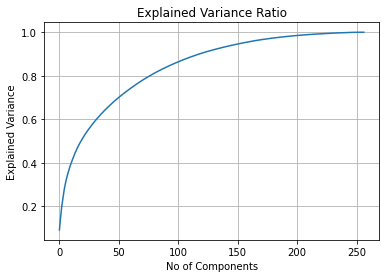

In [65]:
pca_variance(azdias_pca_model)

#### Around 125 component cover 90% of the data.

In [66]:
azdias_pca_model, azdias_pca_transformed_125 = pca_model(filtered_azdias, 125)

### Elbow Method

Done in 22.91 sec.
Done in 43.75 sec.


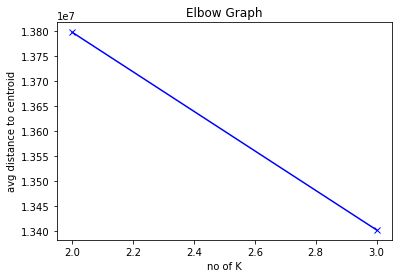

In [67]:
elbow_curve(azdias_pca_transformed_125)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [68]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

F:\Anacinda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [69]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


##### Huge Imbalance in class

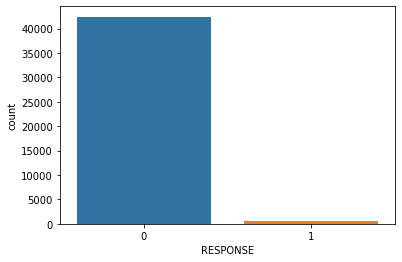

In [70]:
sns.countplot(x="RESPONSE",data=mailout_train);

### Data preprocessing

In [71]:
def data_preprocessing(df, mailout_train, test=False):
    '''This function prepares the MAILOUT_TRAIN dataset 
    for training under the supervised model. This function uses
    the functionality of the above declared functions.
    Args: 
    df: demographic dataframe
    returns: preprocessed dataframe
    '''

    df = handle_mixed_types(df)
    
    replace_unknown(df, unknown)
    additional_missing_values = {'KBA05_MODTEMP': [6.0], 'LP_FAMILIE_FEIN': [0.0], 'LP_FAMILIE_GROB': [0.0],
                            'LP_LEBENSPHASE_FEIN': [0.0], 'LP_LEBENSPHASE_GROB': [0.0], 'ORTSGR_KLS9': [0.0], 'GEBURTSJAHR': [0]}
    replace_unknown(df, additional_missing_values)
    
    missing_cols_df, missing_rows_df = detect_missing_data(df)
    
    cols_to_drop = missing_cols_df.index[missing_cols_df['percentage'] > 30].tolist()
    df = df.drop(cols_to_drop, axis = 1)
    
    cols_to_drop = drop_cols(df)
    for col in ['D19_GESAMT_ANZ_24', 'D19_VERSAND_OFFLINE_DATUM']:
        if col in cols_to_drop:
            cols_to_drop.remove(col)
    df = df.drop(cols_to_drop, axis = 1)

    engineering(df)
    
    df = feature_scaling(df)
    
    return df

##### Applying preprocessing steps on mailout_train dataset 

In [72]:
mailout_train = data_preprocessing(mailout_train, mailout_train)

Replaced ANZ_HAUSHALTE_AKTIV
Replaced KBA13_ANZAHL_PKW
created PRAEGENDE_JUGENDJAHRE_movement
created PRAEGENDE_JUGENDJAHRE_decade
LNR
Imputed LNR
AKT_DAT_KL
Imputed AKT_DAT_KL
ALTERSKATEGORIE_FEIN
Imputed ALTERSKATEGORIE_FEIN
ANZ_HAUSHALTE_AKTIV
Imputed ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
Imputed ANZ_HH_TITEL
ANZ_KINDER
Imputed ANZ_KINDER
ANZ_PERSONEN
Imputed ANZ_PERSONEN
ANZ_TITEL
Imputed ANZ_TITEL
ARBEIT
Imputed ARBEIT
BALLRAUM
Imputed BALLRAUM
Imputed CAMEO_DEU_2015
CAMEO_DEUG_2015
Imputed CAMEO_DEUG_2015
CJT_GESAMTTYP
Imputed CJT_GESAMTTYP
CJT_KATALOGNUTZER
Imputed CJT_KATALOGNUTZER
CJT_TYP_1
Imputed CJT_TYP_1
CJT_TYP_2
Imputed CJT_TYP_2
CJT_TYP_3
Imputed CJT_TYP_3
CJT_TYP_4
Imputed CJT_TYP_4
CJT_TYP_5
Imputed CJT_TYP_5
CJT_TYP_6
Imputed CJT_TYP_6
D19_BANKEN_ANZ_12
Imputed D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
Imputed D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
Imputed D19_BANKEN_DATUM
D19_BANKEN_DIREKT
Imputed D19_BANKEN_DIREKT
D19_BANKEN_GROSS
Imputed D19_BANKEN_GROSS
D19_BANKEN_LOKAL
Imputed

Imputed KBA13_KW_61_120
KBA13_KW_70
Imputed KBA13_KW_70
KBA13_KW_80
Imputed KBA13_KW_80
KBA13_KW_90
Imputed KBA13_KW_90
KBA13_MAZDA
Imputed KBA13_MAZDA
KBA13_MERCEDES
Imputed KBA13_MERCEDES
KBA13_MOTOR
Imputed KBA13_MOTOR
KBA13_NISSAN
Imputed KBA13_NISSAN
KBA13_OPEL
Imputed KBA13_OPEL
KBA13_PEUGEOT
Imputed KBA13_PEUGEOT
KBA13_RENAULT
Imputed KBA13_RENAULT
KBA13_SEG_GELAENDEWAGEN
Imputed KBA13_SEG_GELAENDEWAGEN
KBA13_SEG_GROSSRAUMVANS
Imputed KBA13_SEG_GROSSRAUMVANS
KBA13_SEG_KLEINST
Imputed KBA13_SEG_KLEINST
KBA13_SEG_KLEINWAGEN
Imputed KBA13_SEG_KLEINWAGEN
KBA13_SEG_KOMPAKTKLASSE
Imputed KBA13_SEG_KOMPAKTKLASSE
KBA13_SEG_MINIVANS
Imputed KBA13_SEG_MINIVANS
KBA13_SEG_MINIWAGEN
Imputed KBA13_SEG_MINIWAGEN
KBA13_SEG_MITTELKLASSE
Imputed KBA13_SEG_MITTELKLASSE
KBA13_SEG_OBEREMITTELKLASSE
Imputed KBA13_SEG_OBEREMITTELKLASSE
KBA13_SEG_OBERKLASSE
Imputed KBA13_SEG_OBERKLASSE
KBA13_SEG_SONSTIGE
Imputed KBA13_SEG_SONSTIGE
KBA13_SEG_SPORTWAGEN
Imputed KBA13_SEG_SPORTWAGEN
KBA13_SEG_UTILITIES
Im

In [73]:
mailout_train.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRAEGENDE_JUGENDJAHRE_movement,PRAEGENDE_JUGENDJAHRE_decade
0,0.020538,0.000,0.32,0.034247,0.0,0.0,0.041667,0.0,0.250,0.666667,...,0.0,1.0,1.0,0.375,0.4,0.0,1.0,0.375,1.0,0.0
1,0.020631,0.375,0.52,0.002283,0.0,0.0,0.083333,0.0,0.125,0.666667,...,0.0,0.6,1.0,0.875,0.0,0.0,1.0,0.250,1.0,0.6
2,0.020689,0.000,0.28,0.000000,0.0,0.0,0.000000,0.0,0.375,0.000000,...,0.1,1.0,1.0,0.250,0.4,0.0,0.0,0.375,0.0,0.0
3,0.017006,0.000,0.24,0.009132,0.0,0.0,0.083333,0.0,0.375,0.166667,...,1.0,1.0,1.0,0.125,0.4,0.0,1.0,0.375,0.0,0.0
4,0.020771,0.000,0.36,0.121005,0.0,0.0,0.041667,0.0,0.250,0.500000,...,0.0,1.0,1.0,0.375,0.4,0.0,0.0,0.250,1.0,0.2


In [74]:
mailout_train[mailout_train.columns[mailout_train.dtypes == 'object']]

""
0
1
2
3
4
...
42957
42958
42959
42960


In [75]:
mailout_train_Y=pd.DataFrame(mailout_train['RESPONSE'].values,columns=['RESPONSE'])
mailout_train_X=mailout_train.drop(['RESPONSE', 'LNR'],axis=1)

In [76]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train_X, mailout_train_Y, test_size=0.2)

In [77]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34369 entries, 19497 to 38687
Columns: 344 entries, AKT_DAT_KL to PRAEGENDE_JUGENDJAHRE_decade
dtypes: float64(344)
memory usage: 90.5 MB


In [78]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train.values.ravel())

F:\Anacinda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [79]:
y_pred = lr.predict_proba(X_val)[:,1]
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(lr.score(X_val, y_val)))
print('Logistic regression ROC-AUC: {:.2f}'.format(roc_auc_score(y_val, y_pred)))

Accuracy of logistic regression classifier on validation set: 0.99
Logistic regression ROC-AUC: 0.68


##### The project belongs to the binary classification problem and it has highly imbalanced data. Therefore, I have chosen evaluation metric as the Area Under the Curve Receiver Operating Characteristics (AUC-ROC).

* The AUC-ROC is used to visualize the True Positive Rate against False Positive Rate. If AUC equals to 1, it means that True Positives and True Negatives are disjoined and perfectly distinguishable, while AUC equals 0 means that the models makes exact opposite classification (all true negatives are classified as positives and vice versa).


* AUC has a range of [0, 1]. The greater the value, the better is the performance of our model.

In [80]:
def train_model(model, X_train, y_train, X_val, y_val):
    '''This function customization of the fit method.
    Args: 
    model: instantiated model from the list of the classifiers
    X_train: training data
    y_train: training labels
    X_val: validation data
    y_val: validation labels
    returns: ROC-AUC score, training time
    '''

    t = time.time()
    model = model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict_proba(X_val)[:,1]
    
    roc_score = roc_auc_score(y_val, y_pred)

    train_time = time.time() - t
    
    return roc_score, train_time

In [81]:
classifiers = [
    ("XGBClassifier",xgb.XGBClassifier(random_state=42)),
    ("AdaBoost", AdaBoostClassifier(random_state=42)),
    ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=42))
]

In [82]:
def get_scores(classifiers, X_train, y_train, X_val, y_val):

    result={
    'classifier':[],
    'score':[],
    'train_time':[]
    }
    for name, classifier in classifiers:
        score, t = train_model(classifier, X_train, y_train, X_val, y_val)
        result['classifier'].append(name)
        result['score'].append(score)
        result['train_time'].append(t)
    results_df = pd.DataFrame.from_dict(result, orient='index').transpose()
    return results_df

In [83]:
get_scores(classifiers, X_train, y_train, X_val, y_val)

F:\Anacinda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:22:54] WARNING: D:\Build\xgboost\xgboost-1.3.3.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,classifier,score,train_time
0,XGBClassifier,0.665398,20.8114
1,AdaBoost,0.718096,26.3844
2,GradientBoostingClassifier,0.767401,108.245


In [84]:
mailout_train_X.isnull().sum().sort_values(ascending=False)

PRAEGENDE_JUGENDJAHRE_decade    0
KBA05_CCM1                      0
KBA05_ALTER3                    0
KBA05_ALTER4                    0
KBA05_ANHANG                    0
                               ..
KBA13_KMH_210                   0
KBA13_KMH_211                   0
KBA13_KMH_251                   0
KBA13_KRSAQUOT                  0
AKT_DAT_KL                      0
Length: 344, dtype: int64

##### Performing PCA

In [85]:
mailout_train_X_pca_model, mailout_train_X_pca_transformed = pca_model(mailout_train_X, 190)

In [86]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train_X_pca_transformed, mailout_train_Y, test_size=0.2)

In [87]:
lr.fit(X_train, y_train.values.ravel())

LogisticRegression(random_state=42)

In [88]:
y_pred = lr.predict_proba(X_val)[:,1]
print('Accuracy on validation set: {:.2f}'.format(lr.score(X_val, y_val)))
print('ROC-AUC: {:.2f}'.format(roc_auc_score(y_val, y_pred)))

Accuracy on validation set: 0.99
ROC-AUC: 0.66


In [89]:
get_scores(classifiers, X_train, y_train, X_val, y_val)

F:\Anacinda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:25:34] WARNING: D:\Build\xgboost\xgboost-1.3.3.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,classifier,score,train_time
0,XGBClassifier,0.563981,73.4197
1,AdaBoost,0.640904,88.7504
2,GradientBoostingClassifier,0.583146,432.912


##### Splitting dataset

In [90]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train_X, mailout_train_Y, test_size=0.2)

##### Grid Search
* I have also used Grid Search technique to find the best model parameters and fine tune the model.
* Grid search is an approach to hyperparameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid.

In [91]:
ada_param_dict = {
 'n_estimators': [15, 30],
 'learning_rate' : [0.02,0.04] }

adagrid = GridSearchCV(estimator = AdaBoostClassifier(random_state=42),
                     param_grid = ada_param_dict,
                     scoring = "roc_auc",
                     cv = 2,
                     verbose=2)

In [92]:
adagrid.fit(X_train, y_train.values.ravel())

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] learning_rate=0.02, n_estimators=15 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. learning_rate=0.02, n_estimators=15, total=   4.2s
[CV] learning_rate=0.02, n_estimators=15 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] .............. learning_rate=0.02, n_estimators=15, total=   4.3s
[CV] learning_rate=0.02, n_estimators=30 .............................
[CV] .............. learning_rate=0.02, n_estimators=30, total=   8.2s
[CV] learning_rate=0.02, n_estimators=30 .............................
[CV] .............. learning_rate=0.02, n_estimators=30, total=   8.6s
[CV] learning_rate=0.04, n_estimators=15 .............................
[CV] .............. learning_rate=0.04, n_estimators=15, total=   4.4s
[CV] learning_rate=0.04, n_estimators=15 .............................
[CV] .............. learning_rate=0.04, n_estimators=15, total=   4.4s
[CV] learning_rate=0.04, n_estimators=30 .............................
[CV] .............. learning_rate=0.04, n_estimators=30, total=   8.8s
[CV] learning_rate=0.04, n_estimators=30 .............................
[CV] .............. learning_rate=0.04, n_estimators=30, total=   8.6s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   51.7s finished


GridSearchCV(cv=2, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.02, 0.04],
                         'n_estimators': [15, 30]},
             scoring='roc_auc', verbose=2)

In [93]:
adagrid.best_score_, adagrid.best_params_

(0.7509472000204556, {'learning_rate': 0.04, 'n_estimators': 30})

In [94]:
XGB_param_dict = {
    'n_estimators': [200, 400],
    'max_depth': [4, 6]
}
xgbgrid = GridSearchCV(estimator = xgb.XGBClassifier(random_state=42),
                     param_grid = XGB_param_dict,
                     scoring = "roc_auc",
                     cv = 2,
                     verbose=1)

In [95]:
xgbgrid.fit(X_train, y_train.values.ravel())

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
F:\Anacinda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:35] WARNING: D:\Build\xgboost\xgboost-1.3.3.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anacinda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:49] WARNING: D:\Build\xgboost\xgboost-1.3.3.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anacinda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:04] WARNING: D:\Build\xgboost\xgboost-1.3.3.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anacinda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:33] WARNING: D:\Build\xgboost\xgboost-1.3.3.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anacinda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:01] WARNING: D:\Build\xgboost\xgboost-1.3.3.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anacinda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:23] WARNING: D:\Build\xgboost\xgboost-1.3.3.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anacinda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:45] WARNING: D:\Build\xgboost\xgboost-1.3.3.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anacinda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:39:30] WARNING: D:\Build\xgboost\xgboost-1.3.3.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.6min finished
F:\Anacinda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:40:13] WARNING: D:\Build\xgboost\xgboost-1.3.3.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

In [96]:
xgbgrid.best_score_, xgbgrid.best_params_

(0.6350152507513113, {'max_depth': 6, 'n_estimators': 200})

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [97]:
mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

F:\Anacinda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [98]:
mailout_test['D19_VERSAND_OFFLINE_DATUM']

0         8
1         9
2        10
3         8
4         3
         ..
42828    10
42829    10
42830     8
42831     9
42832     9
Name: D19_VERSAND_OFFLINE_DATUM, Length: 42833, dtype: int64

In [99]:
mailout_test_LNR = mailout_test["LNR"]
mailout_test_LNR

0         1754
1         1770
2         1465
3         1470
4         1478
         ...  
42828    67615
42829    67938
42830    67942
42831    67949
42832    68898
Name: LNR, Length: 42833, dtype: int64

In [100]:
mailout_test = data_preprocessing(mailout_test, mailout_train, test=True)
mailout_test 

Replaced ANZ_HAUSHALTE_AKTIV
Replaced KBA13_ANZAHL_PKW
created PRAEGENDE_JUGENDJAHRE_movement
created PRAEGENDE_JUGENDJAHRE_decade
LNR
Imputed LNR
AKT_DAT_KL
Imputed AKT_DAT_KL
ALTERSKATEGORIE_FEIN
Imputed ALTERSKATEGORIE_FEIN
ANZ_HAUSHALTE_AKTIV
Imputed ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
Imputed ANZ_HH_TITEL
ANZ_KINDER
Imputed ANZ_KINDER
ANZ_PERSONEN
Imputed ANZ_PERSONEN
ANZ_TITEL
Imputed ANZ_TITEL
ARBEIT
Imputed ARBEIT
BALLRAUM
Imputed BALLRAUM
Imputed CAMEO_DEU_2015
CAMEO_DEUG_2015
Imputed CAMEO_DEUG_2015
CJT_GESAMTTYP
Imputed CJT_GESAMTTYP
CJT_KATALOGNUTZER
Imputed CJT_KATALOGNUTZER
CJT_TYP_1
Imputed CJT_TYP_1
CJT_TYP_2
Imputed CJT_TYP_2
CJT_TYP_3
Imputed CJT_TYP_3
CJT_TYP_4
Imputed CJT_TYP_4
CJT_TYP_5
Imputed CJT_TYP_5
CJT_TYP_6
Imputed CJT_TYP_6
D19_BANKEN_ANZ_12
Imputed D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
Imputed D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
Imputed D19_BANKEN_DATUM
D19_BANKEN_DIREKT
Imputed D19_BANKEN_DIREKT
D19_BANKEN_GROSS
Imputed D19_BANKEN_GROSS
D19_BANKEN_LOKAL
Imputed

Imputed KBA13_VORB_1_2
KBA13_VORB_2
Imputed KBA13_VORB_2
KBA13_VORB_3
Imputed KBA13_VORB_3
KBA13_VW
Imputed KBA13_VW
KKK
Imputed KKK
KOMBIALTER
Imputed KOMBIALTER
KONSUMNAEHE
Imputed KONSUMNAEHE
KONSUMZELLE
Imputed KONSUMZELLE
LP_FAMILIE_FEIN
Imputed LP_FAMILIE_FEIN
LP_STATUS_FEIN
Imputed LP_STATUS_FEIN
MIN_GEBAEUDEJAHR
Imputed MIN_GEBAEUDEJAHR
MOBI_RASTER
Imputed MOBI_RASTER
MOBI_REGIO
Imputed MOBI_REGIO
NATIONALITAET_KZ
Imputed NATIONALITAET_KZ
ONLINE_AFFINITAET
Imputed ONLINE_AFFINITAET
ORTSGR_KLS9
Imputed ORTSGR_KLS9
Imputed OST_WEST_KZ
PLZ8_ANTG1
Imputed PLZ8_ANTG1
PLZ8_ANTG2
Imputed PLZ8_ANTG2
PLZ8_ANTG3
Imputed PLZ8_ANTG3
PLZ8_ANTG4
Imputed PLZ8_ANTG4
PLZ8_BAUMAX
Imputed PLZ8_BAUMAX
Imputed PRAEGENDE_JUGENDJAHRE
REGIOTYP
Imputed REGIOTYP
RELAT_AB
Imputed RELAT_AB
RETOURTYP_BK_S
Imputed RETOURTYP_BK_S
RT_KEIN_ANREIZ
Imputed RT_KEIN_ANREIZ
RT_SCHNAEPPCHEN
Imputed RT_SCHNAEPPCHEN
RT_UEBERGROESSE
Imputed RT_UEBERGROESSE
SEMIO_DOM
Imputed SEMIO_DOM
SEMIO_ERL
Imputed SEMIO_ERL
SEMIO_F

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRAEGENDE_JUGENDJAHRE_movement,PRAEGENDE_JUGENDJAHRE_decade
0,0.020421,0.00,0.24,0.005277,0.00,0.000000,0.142857,0.000000,0.250,0.833333,...,0.416667,0.2,1.0,1.0,0.375,0.4,0.0,0.375,0.0,0.0
1,0.020608,0.00,0.00,0.052770,0.00,0.000000,0.071429,0.000000,0.375,1.000000,...,0.083333,0.0,1.0,1.0,0.625,0.4,0.0,0.375,1.0,0.4
2,0.017053,1.00,0.44,0.005277,0.00,0.000000,0.285714,0.000000,0.375,0.000000,...,0.416667,0.2,0.2,1.0,0.500,0.4,1.0,0.375,0.0,0.4
3,0.017111,0.75,0.00,0.002639,0.00,0.000000,0.000000,0.000000,0.375,0.000000,...,0.416667,0.2,1.0,1.0,0.250,0.4,1.0,0.375,1.0,0.4
4,0.017204,0.00,0.52,0.002639,0.00,0.000000,0.285714,0.000000,0.250,0.833333,...,0.250000,0.2,0.4,1.0,0.875,0.6,1.0,0.375,1.0,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42828,0.788104,0.00,0.40,0.017810,0.00,0.000000,0.142857,0.000000,0.250,0.666667,...,0.250000,0.1,1.0,1.0,0.375,0.4,1.0,0.000,1.0,0.2
42829,0.791869,0.00,0.40,0.005277,0.00,0.000000,0.071429,0.000000,0.125,0.833333,...,0.666667,0.5,1.0,1.0,0.375,0.4,0.0,0.375,1.0,0.2
42830,0.791915,0.00,0.60,0.002639,0.00,0.285714,0.214286,0.000000,0.250,0.833333,...,0.000000,0.0,0.0,1.0,0.375,0.2,0.0,0.250,0.0,0.8
42831,0.791997,0.00,0.00,0.002639,0.00,0.000000,0.071429,0.000000,0.375,0.833333,...,0.250000,0.1,1.0,1.0,0.375,0.4,1.0,0.250,0.0,0.6


In [101]:
mailout_test=mailout_test.drop(['LNR'],axis=1)
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 344 entries, AKT_DAT_KL to PRAEGENDE_JUGENDJAHRE_decade
dtypes: float64(344)
memory usage: 112.4 MB


In [102]:
ada_model = adagrid.best_estimator_

##### Fitting AdaBoost model

In [103]:
ada_model.fit(X_train, y_train.values.ravel())

AdaBoostClassifier(learning_rate=0.04, n_estimators=30, random_state=42)

In [104]:
AdaBoost_preds = ada_model.predict_proba(mailout_test)[:,1]

##### Finding features having high impact on the model

In [105]:
def feature_imp(model, mailout_train):
    """
    Plots top n feature importances for the given model
    """
    cols_names = mailout_train.columns
    num_features = 10
    importances = pd.DataFrame({'feature': cols_names, 'value': model.feature_importances_}).sort_values(by='value', ascending = False).reset_index(drop = True)
    print(importances.head(10))
    importances[:10].plot(kind='barh')

                  feature     value
0            D19_SOZIALES  0.833333
1       D19_KONSUMTYP_MAX  0.166667
2              AKT_DAT_KL  0.000000
3           KBA13_KMH_140  0.000000
4  KBA13_KRSHERST_AUDI_VW  0.000000
5          KBA13_KRSAQUOT  0.000000
6           KBA13_KMH_251  0.000000
7           KBA13_KMH_211  0.000000
8           KBA13_KMH_210  0.000000
9           KBA13_KMH_180  0.000000


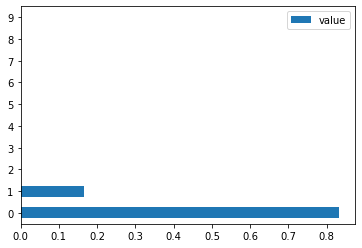

In [106]:
feature_imp(ada_model, X_train)

In [107]:
data = {'RESPONSE': AdaBoost_preds}
final_solution = pd.DataFrame(index=mailout_test_LNR, data=data)

In [108]:
final_solution.to_csv("submissions/Aravato_Submission.csv")